In [1]:
%matplotlib inline
import utils2; reload(utils2)
import importlib
from utils2 import *

/home/nguyentu/anaconda3/envs/py27_tf_cv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
cfg = tf.ConfigProto()
cfg.gpu_options.allow_growth = True
sess = tf.Session(config=cfg)


In [3]:
a = tf.placeholder("float")
b = tf.placeholder("float")
y = tf.multiply(a, b)

print (sess.run(y, feed_dict={a: 3, b: 3}))
print ()

9.0
()


## Simple regression

In [4]:
num_points = 1000
x_data= np.random.normal(0.0, 0.55, (num_points,))
y_data= x_data * 0.1 + 0.3 + np.random.normal(0.0, 0.03, (num_points,))

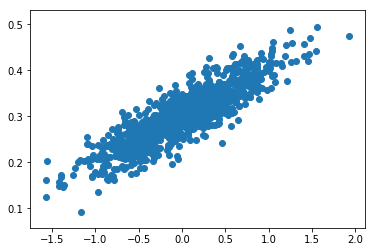

In [5]:
plt.scatter(x_data, y_data);

In [8]:
# - Adapted from the original code in order to have a working example 
x = tf.placeholder("float32")
y = tf.placeholder("float32")
W = tf.Variable(np.random.randn())
b = tf.Variable(np.random.randn())
y_pred = tf.add(tf.multiply(x, W), b)

loss = tf.reduce_mean(tf.square(y_pred - y))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

In [9]:
init = tf.global_variables_initializer()

In [10]:
sess = tf.InteractiveSession(config=cfg)

In [12]:
init.run()
for step in range(8):
    train.run(feed_dict = {x:x_data, y:y_data}, session=sess)
    print (step, W.eval(), b.eval())

(0, 0.27655345, 0.29804927)
(1, 0.22512193, 0.29862627)
(2, 0.18872313, 0.29914504)
(3, 0.1629621, 0.29951218)
(4, 0.14472987, 0.29977202)
(5, 0.1318261, 0.2999559)
(6, 0.12269354, 0.30008608)
(7, 0.11623002, 0.3001782)


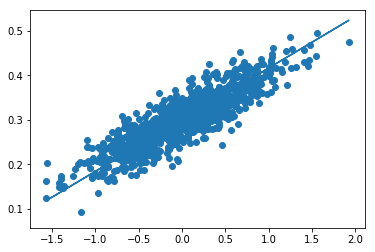

In [13]:
plt.scatter(x_data, y_data)
plt.plot(x_data, W.eval() * x_data + b.eval());

## Variable scope

In [14]:
tf.reset_default_graph()

In [15]:
with tf.variable_scope("foo"):
    v = tf.get_variable("v", [2,3])
v.name

u'foo/v:0'

In [16]:
v.get_shape()

TensorShape([Dimension(2), Dimension(3)])

In [17]:
with tf.variable_scope("foo", reuse=True):
 v1 = tf.get_variable("v", [2,3])

In [18]:
v1==v

True

In [19]:
v2 = tf.get_variable("v2", [1])

In [20]:
v2.name

u'v2:0'

## K-means clustering

In [21]:
def plot_data(data, centroids):
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i])
        plt.plot(centroid[0], centroid[1], markersize=15, marker="x", color='k', mew=10)
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='m', mew=5)
    plt.show()

In [22]:
n_clusters=10
n_samples =250
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

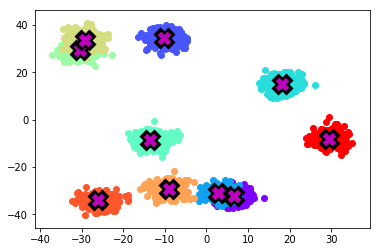

In [23]:
plot_data(data, centroids)

In [34]:
# Numpy Version
def find_initial_centroids_numpy(data, k):
    r_index = np.random.randint(data.shape[0])
    r = data[r_index, :][np.newaxis]
    initial_centroids = []
    for i in range(k):
        diff = data - np.expand_dims(r,1)
        dist = np.linalg.norm(diff, axis=2)  # 100x2  5x2 --> 100x5x2 --> 100x5
        farthest_index = np.argmax(np.min(dist, axis=0))
        farthest_point = data[farthest_index]
        initial_centroids.append(farthest_point)
        r = np.array(initial_centroids)
    return r

In [35]:
def find_initial_centroids(data, k):
    r_index = tf.random_uniform([1], 0, tf.shape(data)[0], dtype=tf.int32)
    r = tf.expand_dims(data[tf.squeeze(r_index)], dim=1)
    initial_centroids = []
    for i in range(k):
        diff = tf.squared_difference(tf.expand_dims(data, 0), tf.expand_dims(r,1))
        dist = tf.reduce_sum(diff, axis=2)
        farthest_index = tf.argmax(tf.reduce_min(dist, axis=0), 0)
        farthest_point = data[tf.to_int32(farthest_index)]
        initial_centroids.append(farthest_point)
#         r = tf.pack(initial_centroids)  # - tf.pack obsolete 
        r = tf.stack(initial_centroids)
    return r

In [38]:
samples = tf.placeholder(tf.float32, (None, None))

In [39]:
# - added this cell to initialize the graph
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [40]:
initial_centroids = find_initial_centroids(samples, n_clusters).eval({samples: data})

In [41]:
def choose_random_centroids(samples, n_clusters):
    n_samples = tf.shape(samples)[0]
    random_indices = tf.random_shuffle(tf.range(0, n_samples))
    centroid_indices = random_indices[:n_clusters]
    return tf.gather(samples, centroid_indices)

In [42]:
initial_centroids = find_initial_centroids_numpy(data, n_clusters)

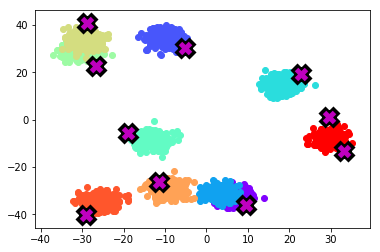

In [43]:
plot_data(data, initial_centroids)

In [44]:
def assign_to_nearest(samples, centroids):
    dim_dists = tf.squared_difference(tf.expand_dims(samples, 0), tf.expand_dims(centroids, 1))
    return tf.argmin(tf.reduce_sum(dim_dists , 2), 0)

In [49]:
def update_centroids(samples, nearest_indices, n_clusters):
    partitions = tf.dynamic_partition(samples, tf.to_int32(nearest_indices), n_clusters)
#     return tf.concat(0, [tf.expand_dims(tf.reduce_mean(partition, 0), 0) 
#                                   for partition in partitions])
    return tf.concat([tf.expand_dims(tf.reduce_mean(partition, 0), 0)  # tf.concat(values, axis) 
                                  for partition in partitions], 0)


In [50]:
initial_centroids = choose_random_centroids(samples, n_clusters).eval({samples: data})

In [51]:
curr_centroids = tf.Variable(initial_centroids)

In [52]:
nearest_indices = assign_to_nearest(samples, curr_centroids)
updated_centroids = update_centroids(samples, nearest_indices, n_clusters)

In [53]:
tf.global_variables_initializer().run()

In [54]:
c = initial_centroids
for i in range(10):
    #TODO animate
    c2 = curr_centroids.assign(updated_centroids).eval({samples: data})
    if np.allclose(c,c2):
        break
    c=c2

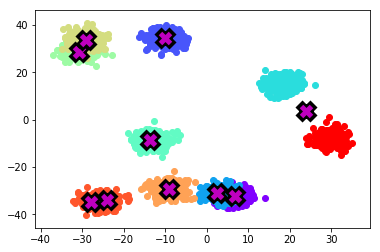

In [55]:
plot_data(data, curr_centroids.eval())

## Tf->Keras LR (working?)

In [61]:
# class LinRegr(Layer):
#     def __init__(self, **kwargs):
#         super(LinRegr, self).__init__(**kwargs)

#     def build(self, input_shape):
#         input_dims = input_shape[1:]
#         self.W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
#         self.b = tf.Variable(tf.zeros([1]))
#         self.built = True

#     def call(self, x, mask=None):
#         return self.W * x + self.b
    
#     def get_output_shape_for(self, input_shape):
#         return input_shape
# - Keras 2
class LinRegr(Layer):
    def __init__(self, **kwargs):
        super(LinRegr, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dims = input_shape[1:]
        self.W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
        self.b = tf.Variable(tf.zeros([1]))
        self.trainable_weights=[self.W, self.b]  # - Without this line there would be no trainable parameters
        super(LinRegr, self).build(input_shape)  # - Could be just "self.built = True" 

    def call(self, x, mask=None):
        return self.W * x + self.b
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [62]:
inp = Input((1,))
res = LinRegr()(inp)

In [63]:
model = Model(inp, res)

In [64]:
model.compile('adam', 'mse')

In [67]:
model.fit(x_data, y_data, verbose=2, epochs=20)

Epoch 1/20
 - 0s - loss: 0.0035
Epoch 2/20
 - 0s - loss: 0.0026
Epoch 3/20
 - 0s - loss: 0.0020
Epoch 4/20
 - 0s - loss: 0.0016
Epoch 5/20
 - 0s - loss: 0.0013
Epoch 6/20
 - 0s - loss: 0.0011
Epoch 7/20
 - 0s - loss: 0.0010
Epoch 8/20
 - 0s - loss: 9.6459e-04
Epoch 9/20
 - 0s - loss: 9.2781e-04
Epoch 10/20
 - 0s - loss: 9.0815e-04
Epoch 11/20
 - 0s - loss: 8.9816e-04
Epoch 12/20
 - 0s - loss: 8.9205e-04
Epoch 13/20
 - 0s - loss: 8.8963e-04
Epoch 14/20
 - 0s - loss: 8.8715e-04
Epoch 15/20
 - 0s - loss: 8.8631e-04
Epoch 16/20
 - 0s - loss: 8.8566e-04
Epoch 17/20
 - 0s - loss: 8.8633e-04
Epoch 18/20
 - 0s - loss: 8.8562e-04
Epoch 19/20
 - 0s - loss: 8.8514e-04
Epoch 20/20
 - 0s - loss: 8.8560e-04
